In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Carregar o dataframe inicial
User = pd.read_excel('EVIO_history_01-02-2023_29-02-2024.xlsx')
User = User[['Start date','Stop date','Duration (min)', 'Total Energy (kWh)', 'Nº cartão EVIO']]

# Remover valores de carregamento de energia inferiores a 1 kWh
User = User[User['Total Energy (kWh)'] >= 1]

User = User[User['Nº cartão EVIO'] == 0]

# Remover valores de duração de carregamento inferiores a 5 minutos
User = User[User['Duration (min)'] >= 5]

User = User[['Start date','Stop date','Duration (min)', 'Total Energy (kWh)']]

print(User)

              Start date           Stop date  Duration (min)  \
31    02/25/2024 | 10:20  02/25/2024 | 10:37          16.500   
35    02/23/2024 | 08:37  02/23/2024 | 11:31         174.000   
52    02/20/2024 | 14:12  02/20/2024 | 20:23         370.850   
61    02/19/2024 | 08:31  02/19/2024 | 11:39         188.083   
91    02/11/2024 | 10:48  02/11/2024 | 11:14          25.983   
...                  ...                 ...             ...   
1536  04/03/2023 | 08:39  04/03/2023 | 13:38         298.967   
1542  03/31/2023 | 08:48  03/31/2023 | 13:36         288.500   
1545  03/31/2023 | 08:41  03/31/2023 | 10:26         105.350   
1548  03/31/2023 | 08:37  03/31/2023 | 08:45           8.283   
1559  03/29/2023 | 08:35  03/29/2023 | 10:26         111.117   

      Total Energy (kWh)  
31                 28.52  
35                 31.10  
52                 27.23  
61                 35.26  
91                 22.06  
...                  ...  
1536               43.80  
1542           

In [3]:
# Convertendo as colunas de data para o formato de data especificado
User['Start date'] = pd.to_datetime(User['Start date'], format='%m/%d/%Y | %H:%M')
User['Stop date'] = pd.to_datetime(User['Stop date'], format='%m/%d/%Y | %H:%M')


# Criando uma nova coluna 'Date' que contém apenas a data (sem a hora)
User['Date'] = User['Start date'].dt.date

# Convertendo os valores de energia para o formato numérico adequado
#User['Total Energy (kWh)'] = User['Total Energy (kWh)'].str.replace(',', '.').astype(float)

# Agrupando os dados pela coluna 'Date' e somando os valores de 'Total Energy (kWh)'
User = User.groupby('Date')['Total Energy (kWh)'].sum().reset_index()

print(User)

           Date  Total Energy (kWh)
0    2023-03-29               12.60
1    2023-03-31               61.66
2    2023-04-03               43.80
3    2023-04-05               51.27
4    2023-04-06               29.33
..          ...                 ...
107  2024-02-11               22.06
108  2024-02-19               35.26
109  2024-02-20               27.23
110  2024-02-23               31.10
111  2024-02-25               28.52

[112 rows x 2 columns]


In [4]:
# Criando um intervalo de datas que cubra todo o período de interesse
date_range = pd.date_range(start=User['Date'].min(), end=User['Date'].max(), freq='D')

# Criando um DataFrame com o intervalo de datas
date_df = pd.DataFrame({'Date': date_range})

# Renomeando a coluna 'Date' para 'Date_new'
date_df.rename(columns={'Date': 'Date_new'}, inplace=True)

# Convertendo a coluna 'Date' em 'daily_energy_sum' para datetime
User['Date'] = pd.to_datetime(User['Date'])

# Mesclando os DataFrames usando merge
merged_df = pd.merge(date_df, User, left_on='Date_new', right_on='Date', how='left')

# Preenchendo os valores ausentes na coluna 'Total Energy (kWh)' com zero
merged_df['Total Energy (kWh)'].fillna(0, inplace=True)
merged_df = merged_df.drop(columns=['Date'])
merged_df.rename(columns={'Date_new': 'Date'}, inplace=True)

print(merged_df)

          Date  Total Energy (kWh)
0   2023-03-29               12.60
1   2023-03-30                0.00
2   2023-03-31               61.66
3   2023-04-01                0.00
4   2023-04-02                0.00
..         ...                 ...
329 2024-02-21                0.00
330 2024-02-22                0.00
331 2024-02-23               31.10
332 2024-02-24                0.00
333 2024-02-25               28.52

[334 rows x 2 columns]


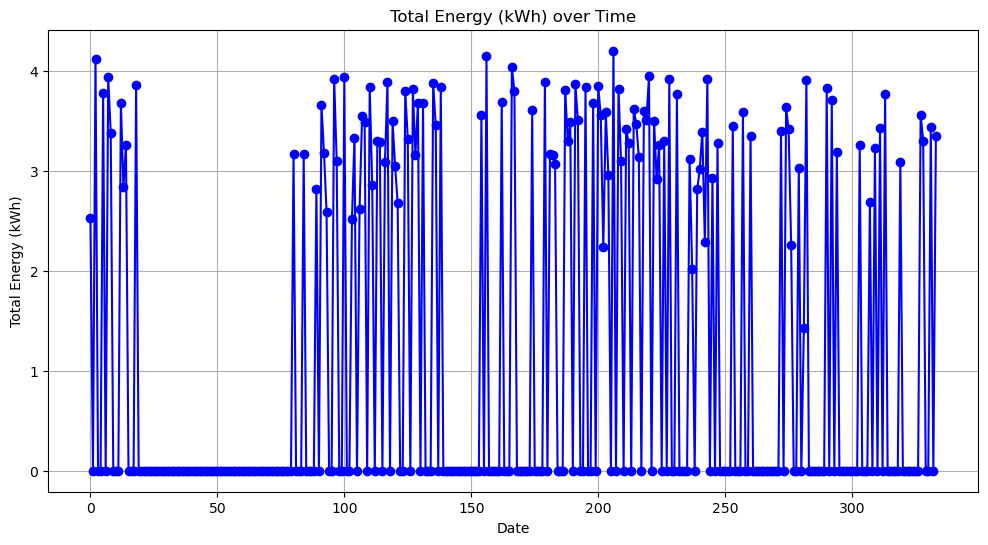

In [12]:
import matplotlib.pyplot as plt
import math

logg=[]
for x in merged_df['Total Energy (kWh)']:
    if x>0:
        logg.append(math.log(x))
    else:
        logg.append(x)

# Plotar a série temporal
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, logg, marker='o', linestyle='-', color='b')
plt.title('Total Energy (kWh) over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.show()

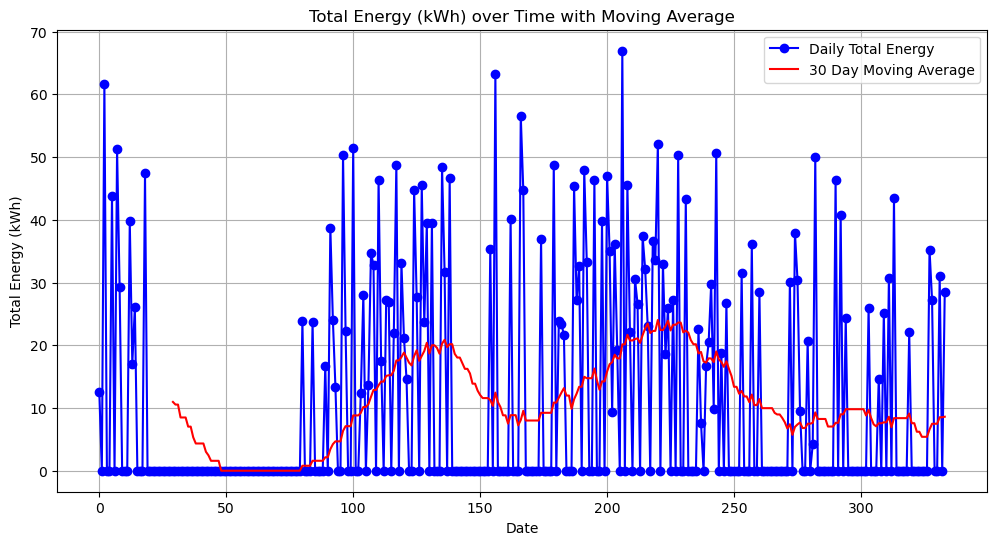

In [5]:
# Aplicar uma média móvel de 30 dias
merged_df['30_day_moving_avg'] = merged_df['Total Energy (kWh)'].rolling(window=30).mean()

# Plotar a série temporal com a média móvel
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Total Energy (kWh)'], marker='o', linestyle='-', color='b', label='Daily Total Energy')
plt.plot(merged_df.index, merged_df['30_day_moving_avg'], color='r', label='30 Day Moving Average')
plt.title('Total Energy (kWh) over Time with Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

#print(merged_df['30_day_moving_avg'])

merged_df.drop(columns=['30_day_moving_avg'], inplace=True)

In [51]:
# Configurar pandas para exibir todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#print(merged_df['30_day_moving_avg'].head(100))
print(merged_df['30_day_moving_avg'])

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29     10.964000
30     10.544000
31     10.544000
32      8.488667
33      8.488667
34      8.488667
35      7.028667
36      7.028667
37      5.319667
38      4.342000
39      4.342000
40      4.342000
41      4.342000
42      3.017333
43      2.448333
44      1.579333
45      1.579333
46      1.579333
47      1.579333
48      0.000000
49      0.000000
50      0.000000
51      0.000000
52      0.000000
53      0.000000
54      0.000000
55      0.000000
56      0.000000
57      0.000000
58      0.0000

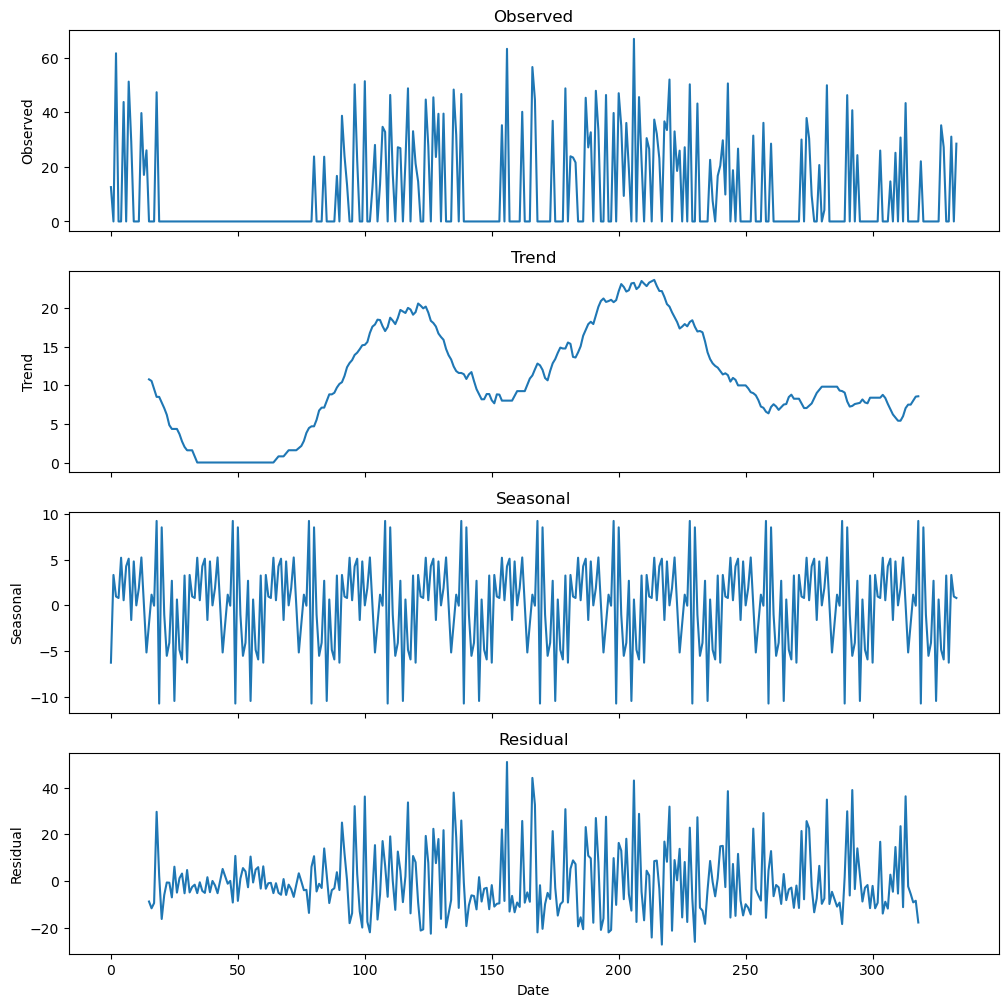

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompor a série temporal
decomposition = seasonal_decompose(merged_df['Total Energy (kWh)'], model='additive', period=30)

# Plotar a decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')

plt.xlabel('Date')
plt.show()

<Figure size 1200x600 with 0 Axes>

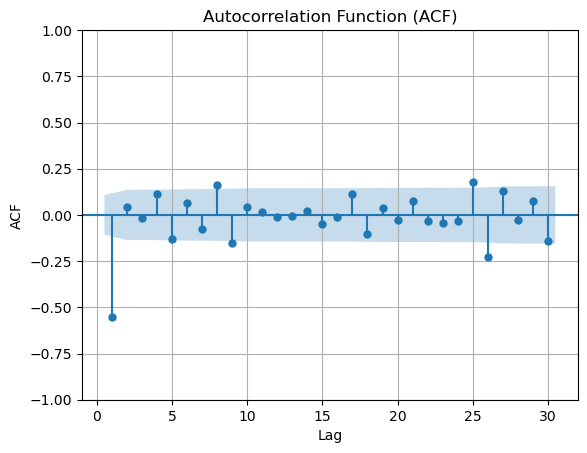

<Figure size 1200x600 with 0 Axes>

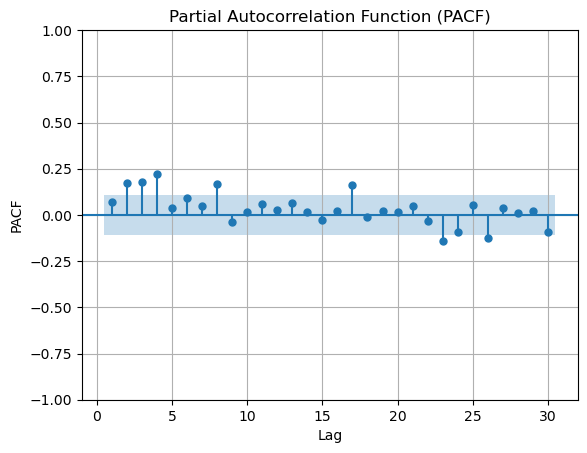

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np

logg2 = np.diff(np.array(logg))

# Plotar ACF
plt.figure(figsize=(12, 6))
plot_acf(logg2, lags=30, zero=False)
#plot_acf(merged_df['Total Energy (kWh)'], lags=30, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plotar PACF
plt.figure(figsize=(12, 6))
plot_pacf(logg, lags=30, zero=False)
#plot_pacf(merged_df['Total Energy (kWh)'], lags=30, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [8]:
from statsmodels.tsa.stattools import kpss

# Executar o teste KPSS
kpss_stat, p_value, lags, crit_values = kpss(merged_df['Total Energy (kWh)'])

# Imprimir os resultados
print(f'KPSS Estatística: {kpss_stat}')
print(f'Valor p: {p_value}')
print('Valores críticos:')
for key, value in crit_values.items():
    print(f'   {key}: {value}')

# Interpretação do teste KPSS
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print(f'\nRejeitar H0: A série NÃO é estacionária.')
else:
    print(f'\nFalha em rejeitar H0: A série é estacionária.')

KPSS Estatística: 0.43151110491937894
Valor p: 0.06357279960371598
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Falha em rejeitar H0: A série é estacionária.


C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 2.28


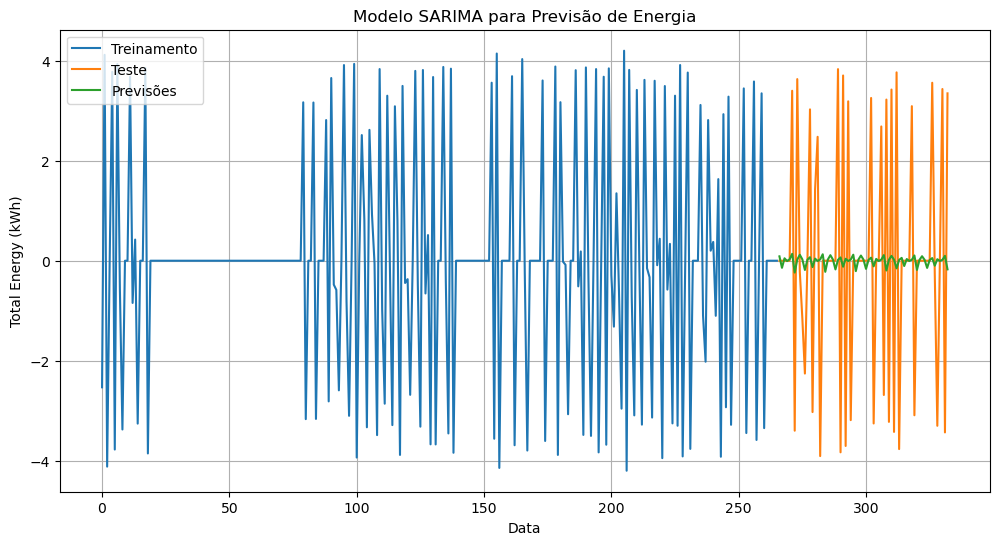

266    0.087643
267   -0.142010
268    0.048434
269   -0.007111
270    0.028475
         ...   
328    0.030636
329   -0.005624
330    0.018021
331    0.097739
332   -0.172742
Name: predicted_mean, Length: 67, dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Usar apenas a coluna 'Total Energy (kWh)' para treinamento
#train = merged_df['Total Energy (kWh)']
train = pd.DataFrame(logg2)

# Dividir em treinamento e teste
train_size = int(len(train) * 0.8)
train_data, test_data = train.iloc[:train_size], train.iloc[train_size:]

# Ajustar o modelo SARIMA
# Exemplo inicial, os parâmetros precisam ser ajustados com base na análise anterior
# Aqui estamos considerando um modelo SARIMA(1, 1, 1)x(1, 0, 1, 12) como exemplo
# Isso significa:
# - p = 1 (ordem do AR)
# - d = 1 (ordem da diferenciação)
# - q = 1 (ordem do MA)
# - P = 1 (ordem do AR sazonal)
# - D = 0 (ordem da diferenciação sazonal)
# - Q = 1 (ordem do MA sazonal)
# - m = 12 (período sazonalidade, aqui assumimos sazonalidade anual com período 12 meses)

#model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test_data))

# Calcular RMSE
rmse = mean_squared_error(test_data, forecast, squared=False)
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Treinamento')
plt.plot(test_data.index, test_data, label='Teste')
plt.plot(test_data.index, forecast, label='Previsões')
plt.title('Modelo SARIMA para Previsão de Energia')
plt.xlabel('Data')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(forecast)

In [11]:
import itertools

# Definir intervalos para os hiperparâmetros
p_values = range(0, 5)  # Substitua os valores conforme necessário
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s_values = [12]  # Frequência sazonal

# Criar uma lista de todas as combinações de hiperparâmetros
hyperparameters = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_rmse = float('inf')
best_hyperparameters = None

# Loop sobre todas as combinações de hiperparâmetros
for params in hyperparameters:
    try:
        # Ajustar o modelo SARIMA com os hiperparâmetros atuais
        model = SARIMAX(train, order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], params[6]))
        model_fit = model.fit(disp=False)
        
        # Fazer previsões
        forecast = model_fit.forecast(steps=len(test))
        
        # Calcular o RMSE
        rmse = sqrt(mean_squared_error(test, forecast))
        
        # Atualizar os melhores hiperparâmetros se o RMSE atual for melhor
        if rmse < best_rmse:
            best_rmse = rmse
            best_hyperparameters = params
    except:
        continue

print(f"Melhores hiperparâmetros: {best_hyperparameters}")
print(f"Melhor RMSE encontrado: {best_rmse}")

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packa

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\s

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:

Melhores hiperparâmetros: None
Melhor RMSE encontrado: inf


In [60]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.9.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.9.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.8.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached pystan-3.

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [56 lines of output]
  C:\Users\miguel.preto\AppData\Local\Temp\pip-install-854oozxr\fbprophet_caa26c7fed31413e85f7c95fc009484a\setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
    from pkg_resources import (
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  NumExpr defaulting to 4 threads.
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\miguel.preto\AppData\Local\Temp\pip-install-854oozxr\fbprophet_caa26c7fed31413e85f7c95fc009484a\setup.py", line 122, in <module>
      setup(
    File "C:\Users\miguel.preto\Anaconda3\lib\site-packages\setuptools\__init__.py", line 10

In [67]:
from fbprophet import Prophet

# Instanciar o modelo
model = Prophet()

# Ajustar o modelo aos dados
model.fit(data)

# Fazer previsões para os próximos períodos
future = model.make_future_dataframe(periods=30)  # Exemplo: prever os próximos 30 dias
forecast = model.predict(future)

# Visualizar as previsões
fig = model.plot(forecast)

ModuleNotFoundError: No module named 'fbprophet'

Date                  datetime64[ns]
Total Energy (kWh)           float64
dtype: object
RMSE: 15.06


C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


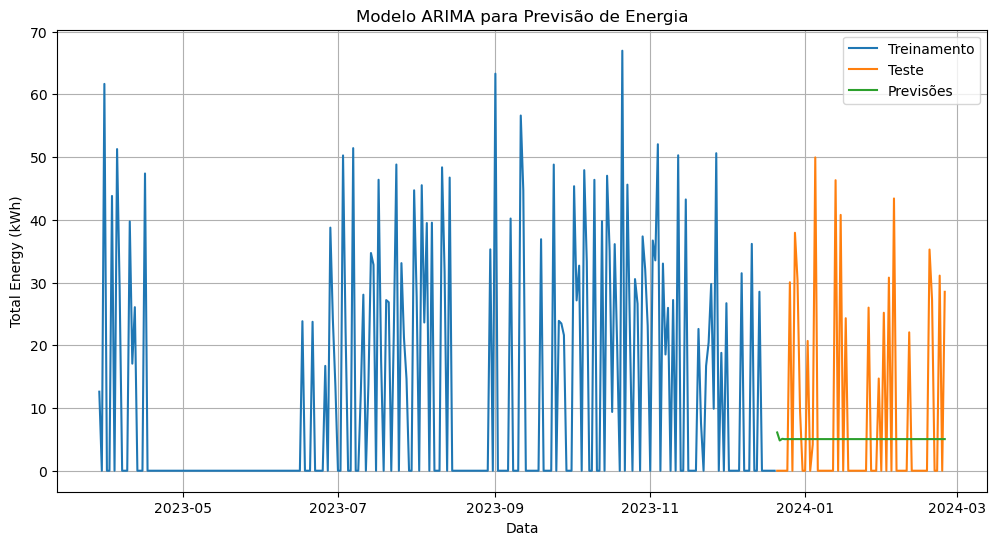

2023-12-21    6.098904
2023-12-22    4.818810
2023-12-23    5.087488
2023-12-24    5.031095
2023-12-25    5.042932
                ...   
2024-02-21    5.040878
2024-02-22    5.040878
2024-02-23    5.040878
2024-02-24    5.040878
2024-02-25    5.040878
Freq: D, Name: predicted_mean, Length: 67, dtype: float64


In [34]:
# Converter a coluna 'Date' para datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Converter a coluna 'Total Energy (kWh)' para float
merged_df['Total Energy (kWh)'] = pd.to_numeric(merged_df['Total Energy (kWh)'], errors='coerce')

# Verificar os tipos das colunas
print(merged_df.dtypes)

# Definir o índice como a coluna 'Date'
merged_df.set_index('Date', inplace=True)

# Dividir em treinamento e teste
train_size = int(len(merged_df) * 0.8)
train = merged_df['Total Energy (kWh)'].iloc[:train_size]
test = merged_df['Total Energy (kWh)'].iloc[train_size:]

# Ajustar o modelo ARIMA
model = ARIMA(train, order=(1, 1, 1))  # Exemplo inicial, ajuste p, d, q conforme necessário
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test))

# Calcular RMSE
rmse = mean_squared_error(test, forecast, squared=False)
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Treinamento')
plt.plot(test.index, test, label='Teste')
plt.plot(test.index, forecast, label='Previsões')
plt.title('Modelo ARIMA para Previsão de Energia')
plt.xlabel('Data')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(forecast)

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

RMSE: 14.68


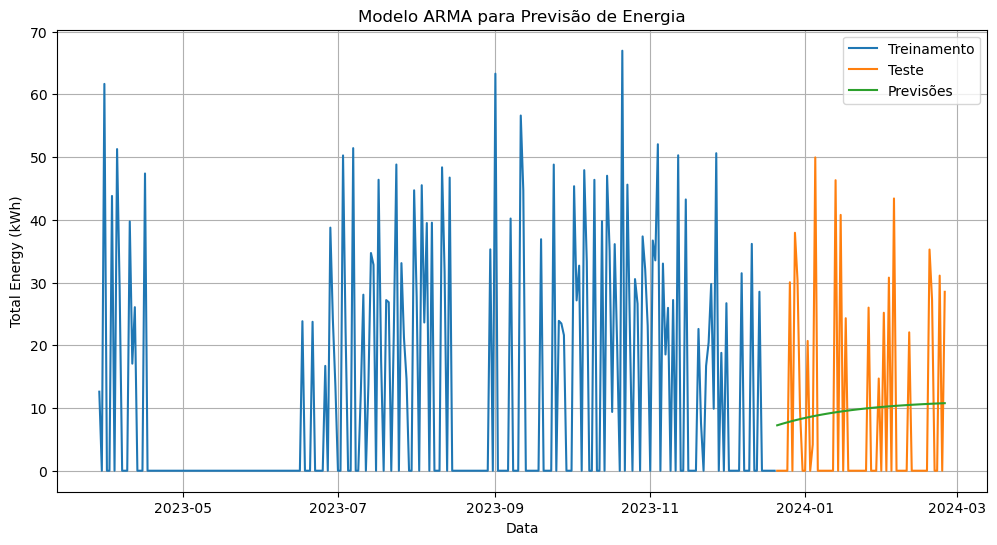

2023-12-21     7.237784
2023-12-22     7.362248
2023-12-23     7.482878
2023-12-24     7.599793
2023-12-25     7.713108
                ...    
2024-02-21    10.698192
2024-02-22    10.716089
2024-02-23    10.733435
2024-02-24    10.750248
2024-02-25    10.766542
Freq: D, Name: predicted_mean, Length: 67, dtype: float64


In [36]:
# Usar apenas a coluna 'Total Energy (kWh)' para treinamento
train = merged_df['Total Energy (kWh)']

# Dividir em treinamento e teste
train_size = int(len(train) * 0.8)
train_data, test_data = train.iloc[:train_size], train.iloc[train_size:]

# Ajustar o modelo ARMA
# Exemplo inicial, os parâmetros precisam ser ajustados com base na análise anterior
# Aqui estamos considerando um modelo ARMA(1, 1) como exemplo
# Isso significa:
# - p = 1 (ordem do AR)
# - q = 1 (ordem do MA)

model = ARIMA(train_data, order=(1, 0, 1))  # Aqui estamos assumindo que a série já está estacionária
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test_data))

# Calcular RMSE
rmse = mean_squared_error(test_data, forecast, squared=False)
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Treinamento')
plt.plot(test_data.index, test_data, label='Teste')
plt.plot(test_data.index, forecast, label='Previsões')
plt.title('Modelo ARMA para Previsão de Energia')
plt.xlabel('Data')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(forecast)

Epoch 1/50
9/9 [==============================] - 2s 4ms/step - loss: 0.0770
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0627
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0628
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0617
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 6/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0612
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 8/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 9/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0613
Epoch 10/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 11/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 12/50
9/9 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 13/50
9/9 [==============================] - 0s 4ms/step - loss: 0.

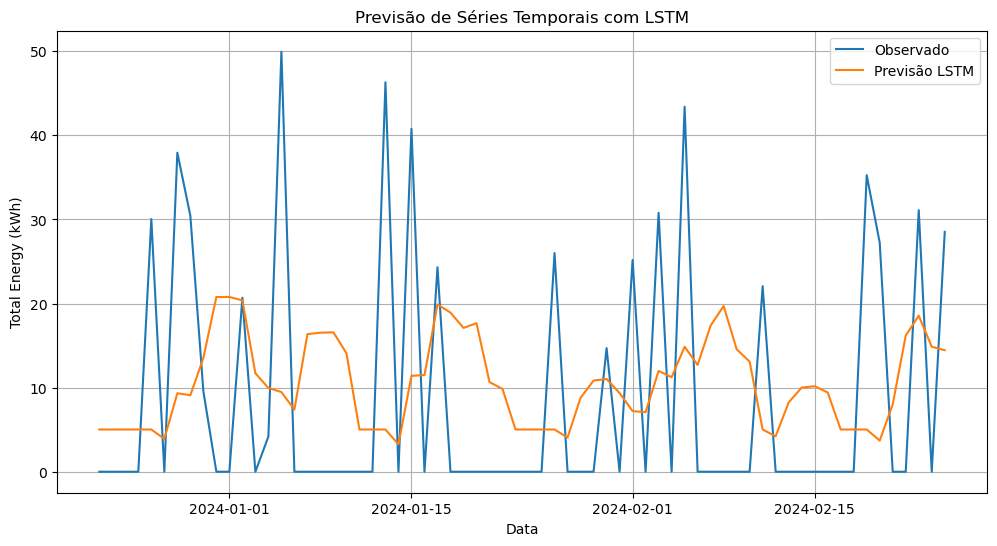

[[ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 3.903634 ]
 [ 9.329761 ]
 [ 9.091535 ]
 [13.520922 ]
 [20.77489  ]
 [20.77696  ]
 [20.373974 ]
 [11.707348 ]
 [ 9.959053 ]
 [ 9.471463 ]
 [ 7.3963714]
 [16.360514 ]
 [16.530842 ]
 [16.56949  ]
 [14.093692 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 3.2517564]
 [11.400882 ]
 [11.490465 ]
 [19.893671 ]
 [18.916246 ]
 [17.100662 ]
 [17.66148  ]
 [10.658931 ]
 [ 9.838401 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 4.0610986]
 [ 8.786635 ]
 [10.842402 ]
 [11.0232   ]
 [ 9.352281 ]
 [ 7.206752 ]
 [ 7.080791 ]
 [11.981331 ]
 [11.237675 ]
 [14.857597 ]
 [12.691205 ]
 [17.380562 ]
 [19.705988 ]
 [14.569931 ]
 [13.082613 ]
 [ 5.019739 ]
 [ 4.21271  ]
 [ 8.245939 ]
 [10.002632 ]
 [10.168427 ]
 [ 9.425851 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 5.019739 ]
 [ 3.697398 ]
 [ 8.021703 ]
 [16.181812 ]
 [18.555311 ]
 [14.858691 ]
 [14.445552 ]]


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Usar apenas a coluna 'Total Energy (kWh)' para treinamento
data = merged_df['Total Energy (kWh)'].values.reshape(-1, 1)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para criar sequências temporais para o LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o comprimento da sequência (por exemplo, 5 dias anteriores para prever o próximo dia)
seq_length = 5
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjunto de treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para o formato [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Construção do Modelo LSTM

model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Fazer previsões
predictions = model.predict(X_test)

# Inverter a escala das previsões para desnormalizar
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_test):], y_test, label='Observado')
plt.plot(merged_df.index[-len(predictions):], predictions, label='Previsão LSTM')
plt.title('Previsão de Séries Temporais com LSTM')
plt.xlabel('Data')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(predictions)

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE: 227.66230180936546
MAE: 13.31976451507056
RMSE: 15.08848242234339
R²: -0.0657079064866175


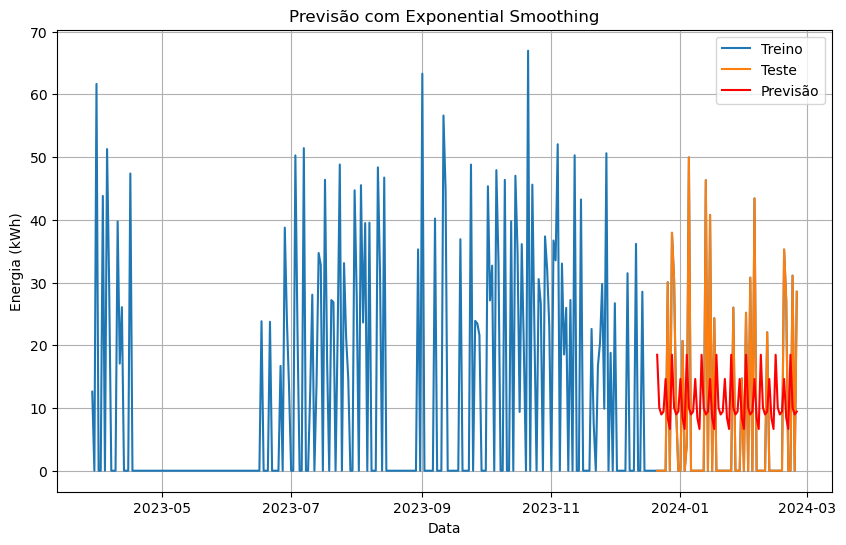

2024-02-26    18.485916
2024-02-27    10.039178
2024-02-28     8.965471
2024-02-29     9.438751
2024-03-01    14.624096
                ...    
2024-04-28     6.654639
2024-04-29    18.485916
2024-04-30    10.039178
2024-05-01     8.965471
2024-05-02     9.438751
Freq: D, Length: 67, dtype: float64


In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Ajustando o modelo de suavização exponencial
exp_model = ExponentialSmoothing(train, seasonal='add').fit()

# Fazendo previsões
forecast_exp = exp_model.forecast(len(test))


# Calculando as métricas de avaliação do modelo
mse = mean_squared_error(test, forecast_exp)
mae = mean_absolute_error(test, forecast_exp)
rmse = sqrt(mse)
r2 = r2_score(test, forecast_exp)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, label='Treino')
plt.plot(test.index, test.values, label='Teste')
plt.plot(test.index, forecast_exp, label='Previsão', color='red')
plt.title('Previsão com Exponential Smoothing')
plt.xlabel('Data')
plt.ylabel('Energia (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(forecast_exp)

[array([0.18820015, 0.        , 0.92098581, 0.        , 0.        ,
       0.65421957, 0.        , 0.76579537, 0.43808813, 0.        ,
       0.        , 0.        , 0.5935773 , 0.25496639, 0.38939507,
       0.        , 0.        , 0.        , 0.70769231, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.        , 0.92098581, 0.        , 0.        , 0.65421957,
       0.        , 0.76579537, 0.43808813, 0.        , 0.        ,
       0.        , 0.5935773 , 0.25496639, 0.38939507, 0.        ,
       0.        , 0.        , 0.70769231, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.92098581, 0.        , 0.        , 0.65421957, 0.        ,
       0.76579537, 0.43808813, 0.        , 0.        , 0.        ,
       0.5935773 , 0.25496639, 0.38939507, 0.        , 0.

Epoch 1/50
7/7 [==============================] - 8s 270ms/step - loss: 0.0645 - val_loss: 0.0770
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0607 - val_loss: 0.0739
Epoch 3/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0599 - val_loss: 0.0736
Epoch 4/50
7/7 [==============================] - 0s 43ms/step - loss: 0.0576 - val_loss: 0.0741
Epoch 5/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0574 - val_loss: 0.0737
Epoch 6/50
7/7 [==============================] - 0s 49ms/step - loss: 0.0588 - val_loss: 0.0737
Epoch 7/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0576 - val_loss: 0.0738
Epoch 8/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0574 - val_loss: 0.0740
Epoch 9/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0577 - val_loss: 0.0737
Epoch 10/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0580 - val_loss: 0.0738
Epoch 11/50
7/7 [===========

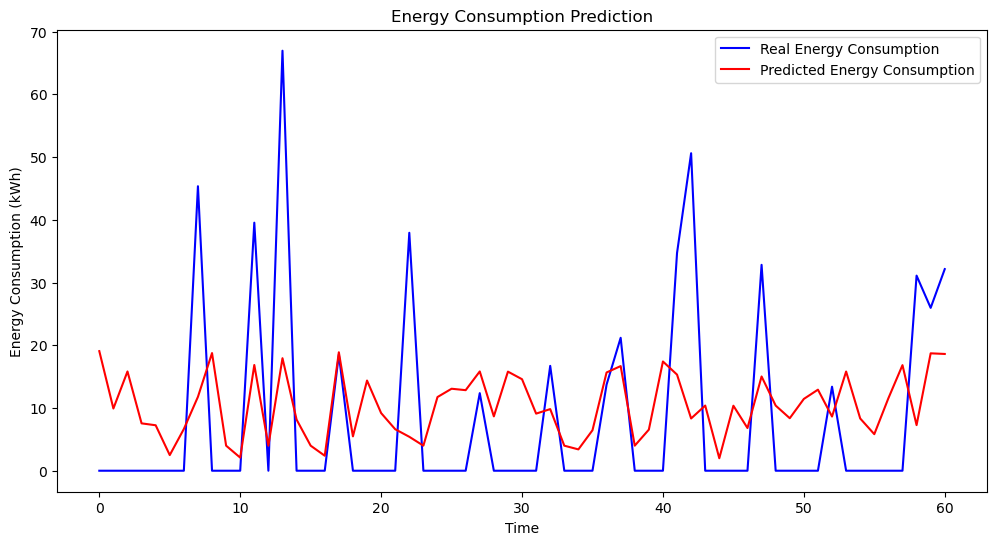

[[19.063179 ]
 [ 9.91744  ]
 [15.821463 ]
 [ 7.5496383]
 [ 7.2469144]
 [ 2.4915407]
 [ 6.648279 ]
 [11.779406 ]
 [18.755226 ]
 [ 3.9925122]
 [ 2.0884418]
 [16.85157  ]
 [ 3.9925122]
 [17.938229 ]
 [ 8.153327 ]
 [ 3.9925122]
 [ 2.3877652]
 [18.879204 ]
 [ 5.4758945]
 [14.376193 ]
 [ 9.191482 ]
 [ 6.6131525]
 [ 5.408741 ]
 [ 3.9925122]
 [11.743624 ]
 [13.068479 ]
 [12.841621 ]
 [15.825435 ]
 [ 8.663554 ]
 [15.797246 ]
 [14.585773 ]
 [ 9.101876 ]
 [ 9.822919 ]
 [ 3.9925122]
 [ 3.4002106]
 [ 6.4519014]
 [15.661683 ]
 [16.68013  ]
 [ 3.9925122]
 [ 6.548622 ]
 [17.41205  ]
 [15.319224 ]
 [ 8.328639 ]
 [10.386431 ]
 [ 1.9877037]
 [10.361176 ]
 [ 6.8046503]
 [15.023742 ]
 [10.385436 ]
 [ 8.369087 ]
 [11.445421 ]
 [12.9207735]
 [ 8.635286 ]
 [15.812807 ]
 [ 8.326127 ]
 [ 5.8264804]
 [11.55568  ]
 [16.829361 ]
 [ 7.268621 ]
 [18.714342 ]
 [18.613522 ]]
RMSE: 14.74


In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Supondo que merged_df é o dataframe que contém os dados de consumo de energia

# Verificar dados nulos
merged_df.isna().sum()

# Preencher ou remover valores nulos
merged_df = merged_df.fillna(0)

# Normalizar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df['Total Energy (kWh)'].values.reshape(-1, 1))

# Preparar dados para treino
X = []
y = []

window_size = 30
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])


X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo
model = Sequential()

# Adicionar camadas LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adicionar camada densa de saída
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

import matplotlib.pyplot as plt

# Avaliar o modelo
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Fazer previsões
predicted_energy = model.predict(X_test)
predicted_energy = scaler.inverse_transform(predicted_energy.reshape(-1, 1))
real_energy = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(real_energy, color='blue', label='Real Energy Consumption')
plt.plot(predicted_energy, color='red', label='Predicted Energy Consumption')
plt.title('Energy Consumption Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

print(predicted_energy)
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcular o RMSE entre os valores reais e previstos
rmse = np.sqrt(mean_squared_error(real_energy, predicted_energy))
print(f'RMSE: {rmse:.2f}')